In [24]:
!pip install --upgrade tables
!pip install eli5

Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.6.1)


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import eli5
from eli5.sklearn import PermutationImportance

from tqdm import tqdm_notebook as tqdm

## Reading data

In [26]:
cd "/content/drive/My Drive/Colab Notebooks/Booking_hotel_dir"

/content/drive/My Drive/Colab Notebooks/Booking_hotel_dir


In [27]:
my_data = pd.read_csv('hotel_bookings.csv')
my_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [28]:
del my_data['reservation_status']
my_data.shape

(119390, 31)

In [29]:
missing_val_count_by_column = (my_data.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

children         4
country        488
agent        16340
company     112593
dtype: int64


#### I will delete column agent and company and rows which doesn't have value for column country and children

In [30]:
del my_data['company']
del my_data['agent']

my_data.dropna(axis=0)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.00,0,0,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.00,0,0,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.00,0,0,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.00,0,0,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.00,0,1,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,96.14,0,0,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,0,Transient,225.43,0,2,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,0,Transient,157.71,0,4,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,104.40,0,0,2017-09-07


In [0]:
y = my_data['is_canceled']
del my_data['is_canceled']

In [0]:
for col in my_data.columns:
  my_data[col + '_cat'] = my_data[col].factorize()[0]

In [33]:
feats_cat = []
for col in my_data.columns:
  if '_cat' in str(col):
    feats_cat.append(str(col))

feats_cat

['hotel_cat',
 'lead_time_cat',
 'arrival_date_year_cat',
 'arrival_date_month_cat',
 'arrival_date_week_number_cat',
 'arrival_date_day_of_month_cat',
 'stays_in_weekend_nights_cat',
 'stays_in_week_nights_cat',
 'adults_cat',
 'children_cat',
 'babies_cat',
 'meal_cat',
 'country_cat',
 'market_segment_cat',
 'distribution_channel_cat',
 'is_repeated_guest_cat',
 'previous_cancellations_cat',
 'previous_bookings_not_canceled_cat',
 'reserved_room_type_cat',
 'assigned_room_type_cat',
 'booking_changes_cat',
 'deposit_type_cat',
 'days_in_waiting_list_cat',
 'customer_type_cat',
 'adr_cat',
 'required_car_parking_spaces_cat',
 'total_of_special_requests_cat',
 'reservation_status_date_cat']

In [34]:
X = my_data[feats_cat].values

model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
np.mean(scores)*100

-50.21210397311587

In [35]:
X = my_data[feats_cat].values

m = DecisionTreeRegressor(max_depth=5)
m.fit(X, y)

imp = PermutationImportance(m, random_state=0).fit(X, y)
eli5.show_weights(imp, feature_names=feats_cat)

Weight,Feature
0.3028 ± 0.0063,deposit_type_cat
0.1544 ± 0.0022,market_segment_cat
0.1205 ± 0.0036,previous_cancellations_cat
0.0995 ± 0.0016,country_cat
0.0833 ± 0.0018,required_car_parking_spaces_cat
0.0246 ± 0.0009,previous_bookings_not_canceled_cat
0.0097 ± 0.0008,adr_cat
0.0016 ± 0.0002,customer_type_cat
0.0004 ± 0.0001,reservation_status_date_cat
0 ± 0.0000,reserved_room_type_cat


In [0]:
the_most_important_feats=["deposit_type_cat",
"market_segment_cat",
"previous_cancellations_cat",
"country_cat",
"required_car_parking_spaces_cat",
"previous_bookings_not_canceled_cat",
"adr_cat",
"customer_type_cat",
"reservation_status_date_cat" ]

In [37]:
X = my_data[the_most_important_feats].values

model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
np.mean(scores)*100

-38.85270825678908

In [38]:
X = my_data[the_most_important_feats].values

m = DecisionTreeRegressor(max_depth=5)
m.fit(X, y)

imp = PermutationImportance(m, random_state=0).fit(X, y)
eli5.show_weights(imp, feature_names=the_most_important_feats)

Weight,Feature
0.3010 ± 0.0058,deposit_type_cat
0.1542 ± 0.0020,market_segment_cat
0.1205 ± 0.0020,previous_cancellations_cat
0.0992 ± 0.0019,country_cat
0.0839 ± 0.0025,required_car_parking_spaces_cat
0.0242 ± 0.0012,previous_bookings_not_canceled_cat
0.0095 ± 0.0017,adr_cat
0.0016 ± 0.0003,customer_type_cat
0.0003 ± 0.0001,reservation_status_date_cat


In [0]:
important_feats = [ "deposit_type_cat",
"market_segment_cat",
"previous_cancellations_cat",
"country_cat",
"required_car_parking_spaces_cat",
"previous_bookings_not_canceled_cat"]

In [40]:
X = my_data[important_feats].values

model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
np.mean(scores)*100

-37.50226479315562

In [41]:
m = DecisionTreeRegressor(max_depth=5)
m.fit(X, y)

imp = PermutationImportance(m, random_state=0).fit(X, y)
eli5.show_weights(imp, feature_names=important_feats)

Weight,Feature
0.2743 ± 0.0039,deposit_type_cat
0.1768 ± 0.0025,country_cat
0.1566 ± 0.0022,market_segment_cat
0.1211 ± 0.0024,previous_cancellations_cat
0.0837 ± 0.0015,required_car_parking_spaces_cat
0.0242 ± 0.0011,previous_bookings_not_canceled_cat


###Random Forest

In [42]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)

scores = cross_val_score(forest_model, val_X, val_y, cv=3, scoring='neg_mean_absolute_error')
np.mean(scores)*100

-28.163903498296722

In [43]:
n_estimators = [2, 4, 8, 16, 32, 64, 100, 200]
max_depths = np.linspace(1, 32, 32, endpoint=True)
res = []
res_tab = [0]*len(n_estimators)

for i, estm in enumerate(n_estimators):
  res_tab[i] =[]
  for md in max_depths:
    
    forest_model_adv = RandomForestRegressor(max_depth=md, n_estimators=estm, random_state=1)
    forest_model_adv.fit(train_X, train_y)

    scores = cross_val_score(forest_model_adv, val_X, val_y, cv=3, scoring='neg_mean_absolute_error')
    sc_m = np.mean(scores)*100
    res.append([sc_m, estm, md])
    res_tab[i].append(sc_m)

res.sort(reverse=True)
res[0]

[-28.154887393617035, 2, 32.0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


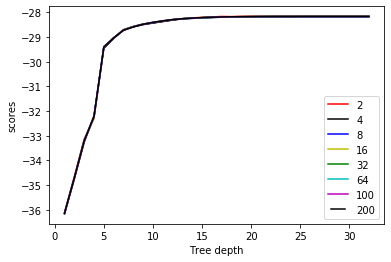

In [44]:
color = ['r', 'black', 'b', 'y', 'g', 'c', 'm', 'k']
for i, co in enumerate(color):
  line, = plt.plot(max_depths, res_tab[i], co, label=str(n_estimators[i]))
    
plt.legend(handler_map={line: HandlerLine2D(numpoints=2)})
axes = plt.axes()
plt.ylabel('scores')
plt.xlabel('Tree depth')
plt.show();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


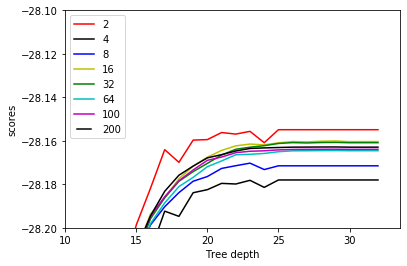

In [49]:
for i, co in enumerate(color):
  line, = plt.plot(max_depths, res_tab[i], co, label=str(n_estimators[i]))
    
plt.legend(handler_map={line: HandlerLine2D(numpoints=2)})
axes = plt.axes()
axes.set_xlim(left=10)
axes.set_ylim(bottom=-28.2, top=-28.1)
plt.ylabel('scores')
plt.xlabel('Tree depth')
plt.show();